# Imports

In [1]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
import gc

import wandb
from fastai.callback.wandb import *

wandb.login(key="11b470b697ff94b3896d2243b147d42177a5cb7a")
wandb.init(project="cassava", entity="teo03")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: teo03 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.13 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


# Setup

In [2]:
path_str = '../input/cassava-leaf-disease-classification'
PATH = Path(path_str)

images_path = Path(path_str + '/train_images')
csv_path = Path(path_str + '/train.csv')

# Some Data Analysis

Get the default image height and width

In [3]:
test_image = Image.open((images_path).ls()[6])

test_image.shape

(600, 800)

View the csv data

In [4]:
train_df = pd.read_csv(csv_path)
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

# Create a smaller dataset

In [5]:
msk = np.random.rand(len(train_df)) < 0.1

In [6]:
train_df = train_df[msk]
train_df['label'].value_counts(), len(train_df)

# Data Preprocessing

In [7]:
def get_x(row): return images_path/row['image_id']
def get_y(row): return row['label']

In [8]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2),
        item_tfms=[Resize(384), FlipItem(p=0.4), RandomCrop(300)],
        batch_tfms=[RandomResizedCropGPU(280), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
    )

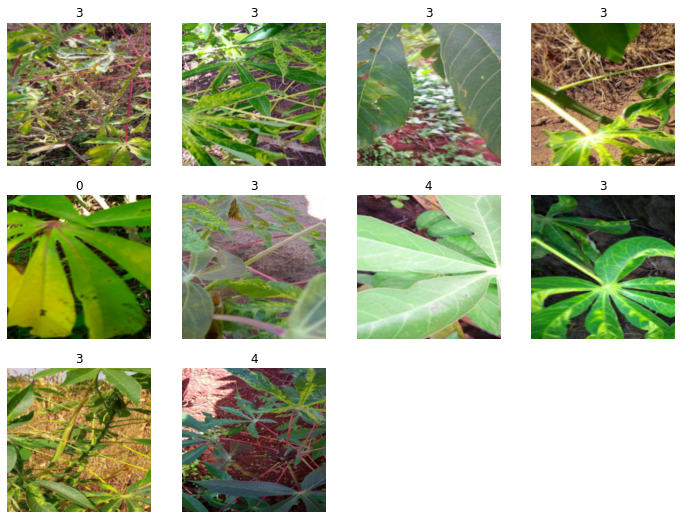

In [9]:
dls = block.dataloaders(train_df, bs=64)

dls.train.show_batch(max_n=10)

# Modelling

In [10]:
def train(arch, epochs=25, freeze_epochs=10):
    learn = cnn_learner(
        dls,
        arch,
        metrics=accuracy,
        loss_func=LabelSmoothingCrossEntropy(),
        cbs=[
            WandbCallback(log_preds=True, log_model=True, n_preds=10),
            SaveModelCallback(fname=str(arch.__name__)),
            EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=3)
        ],
        opt_func=ranger,
    )
    
    lr_min, lr_steep = learn.lr_find()
    
    learn.fine_tune(epochs, base_lr=round(lr_min, 5), freeze_epochs=freeze_epochs)
    
    return learn

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.305511,1.015987,0.724001,06:14
1,0.980656,0.899153,0.769339,05:44
2,0.920083,0.853259,0.780790,05:39
3,0.865363,0.777994,0.813742,05:45
4,0.823732,0.813154,0.800187,05:50
5,0.767999,0.727089,0.835943,05:50
6,0.786214,0.730805,0.834541,05:51
7,0.777420,0.710739,0.843889,05:51
8,0.775981,0.853848,0.792008,05:48


Better model found at epoch 0 with valid_loss value: 1.0159868001937866.
Better model found at epoch 1 with valid_loss value: 0.8991528749465942.
Better model found at epoch 2 with valid_loss value: 0.8532587885856628.
Better model found at epoch 3 with valid_loss value: 0.7779935598373413.
Better model found at epoch 5 with valid_loss value: 0.7270889282226562.
Better model found at epoch 7 with valid_loss value: 0.7107388377189636.
No improvement since epoch 5: early stopping


wandb: Adding directory to artifact (/tmp/tmpepsqonz4)... Done. 0.4s


epoch,train_loss,valid_loss,accuracy,time
0,0.790352,0.788733,0.797149,06:20
1,0.804126,0.817069,0.788736,06:18
2,0.796047,0.856982,0.772610,06:21
3,0.802273,0.788687,0.806497,06:21


Exception ignored in: <finalize object at 0x7f9b44d4be10; dead>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/weakref.py", line 572, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "/opt/conda/lib/python3.7/tempfile.py", line 797, in _cleanup
    _shutil.rmtree(name)
  File "/opt/conda/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/opt/conda/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpepsqonz4'


Better model found at epoch 0 with valid_loss value: 0.7887329459190369.
Better model found at epoch 3 with valid_loss value: 0.7886865139007568.
No improvement since epoch 0: early stopping


wandb: Adding directory to artifact (/tmp/tmp36mu1y1s)... Done. 0.4s


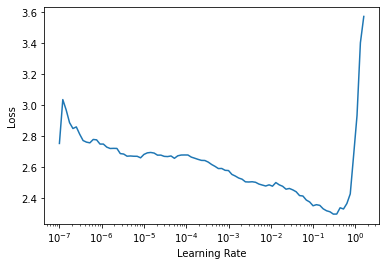

In [11]:
resnet101_learner = train(resnet101, 1, 1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.453657,1.136123,0.680065,05:17
1,1.081720,0.939856,0.739659,05:20
2,0.918410,0.860359,0.773779,05:18
3,0.880018,0.851089,0.780790,05:20
4,0.846231,0.799775,0.798785,05:19
5,0.827639,0.760096,0.818416,05:18
6,0.780687,0.736510,0.826361,05:19
7,0.772447,0.724251,0.841785,05:18
8,0.775365,0.757248,0.827997,05:19
9,0.762052,0.693134,0.857911,05:17


Better model found at epoch 0 with valid_loss value: 1.1361228227615356.
Better model found at epoch 1 with valid_loss value: 0.9398556351661682.
Better model found at epoch 2 with valid_loss value: 0.8603588938713074.
Better model found at epoch 3 with valid_loss value: 0.8510887026786804.
Better model found at epoch 4 with valid_loss value: 0.7997751832008362.
Better model found at epoch 5 with valid_loss value: 0.7600958347320557.
Better model found at epoch 6 with valid_loss value: 0.7365097999572754.
Better model found at epoch 7 with valid_loss value: 0.7242507934570312.
Better model found at epoch 9 with valid_loss value: 0.6931341886520386.


wandb: Adding directory to artifact (/tmp/tmpmn3e6aqa)... Done. 0.2s


epoch,train_loss,valid_loss,accuracy,time
0,0.736992,0.725190,0.840383,05:36
1,0.773430,0.736438,0.837345,05:34
2,0.774538,0.888056,0.743865,05:35
3,0.765274,0.708909,0.846459,05:33


Better model found at epoch 0 with valid_loss value: 0.7251896262168884.
Better model found at epoch 3 with valid_loss value: 0.7089092135429382.
No improvement since epoch 0: early stopping


wandb: Adding directory to artifact (/tmp/tmp5pr11brk)... Done. 0.2s


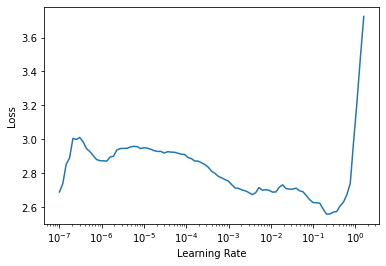

In [12]:
resnet50_learner = train(resnet50, 1, 1)

In [13]:
submission_df = pd.read_csv(path_str + '/sample_submission.csv')
test_data_path = submission_df['image_id'].apply(lambda x: path_str+'/test_images/'+x)

resnet50_tst_dl = resnet50_learner.dls.test_dl(test_data_path)
resnet101_tst_dl = resnet101_learner.dls.test_dl(test_data_path)

resnet50_predictions = resnet50_learner.tta(dl=resnet50_tst_dl, n=2)
resnet101_predictions = resnet101_learner.tta(dl=resnet101_tst_dl, n=2)

predictions = (resnet50_predictions[0] + resnet101_predictions[0]) / 2

wandb: Adding directory to artifact (/tmp/tmpreoc99et)... Done. 0.2s


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [14]:
submission_df['label'] = np.argmax(predictions, axis=1)

submission_df.to_csv('submission.csv', index=False)

NameError: name 'predictions' is not defined